In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

##### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data_treated/train.csv')
df_val = pd.read_csv('../data_treated/validation.csv')
df_test = pd.read_csv('../data_treated/test.csv')

In [3]:
X_train = df_train.drop(['satisfaction'], axis=1).values
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1).values
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1).values
y_test = df_test['satisfaction'].values

##### Criando o modelo MLP

In [4]:
model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(50, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(2, activation='softmax')
])

In [5]:
model.compile(
    optimizer=Adam(), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    min_delta=0.001,
    restore_best_weights=True
)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852 (7.23 KB)

 Trainable params: 1,852 (7.23 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train,
    y_train, 
    epochs=15, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8282 - loss: 0.3930 - val_accuracy: 0.9037 - val_loss: 0.2522
Epoch 2/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8988 - loss: 0.2580 - val_accuracy: 0.9179 - val_loss: 0.2023
Epoch 3/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9113 - loss: 0.2191 - val_accuracy: 0.9289 - val_loss: 0.1788
Epoch 4/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9222 - loss: 0.1907 - val_accuracy: 0.9321 - val_loss: 0.1669
Epoch 5/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9262 - loss: 0.1786 - val_accuracy: 0.9372 - val_loss: 0.1542
Epoch 6/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9307 - loss: 0.1677 - val_accuracy: 0.9385 - val_loss: 0.1476
Epoch 7/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9335 - loss: 0.1591 - val_accuracy: 0.9383 - val_loss: 0.1459
Epoch 8/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9371 - loss: 0.1534 - 

##### Avaliando o modelo

In [29]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {test_accuracy:.4f}")

2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step - accuracy: 0.9520 - loss: 0.1149
Accuracy on test data: 0.9518


In [22]:
y_pred = np.argmax(model.predict(X_test), axis=1)

2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


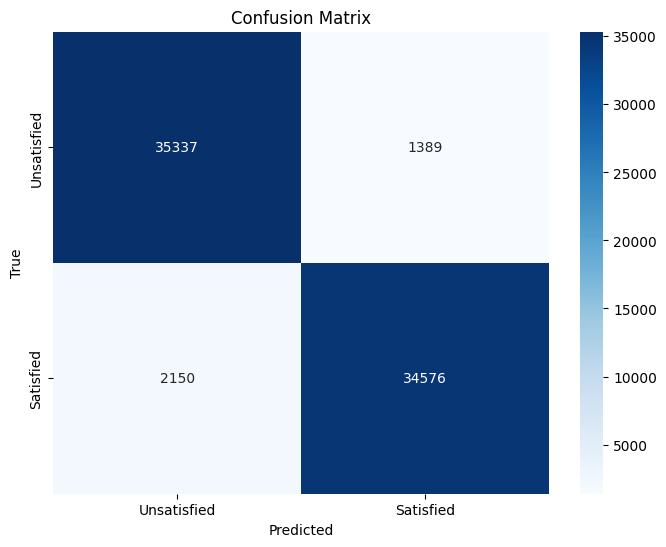

In [30]:
plot_confusion_matrix(y_pred=y_pred, y_test=y_test)